# CI project :Natural-inspired pattern Recognition for Classification Proplem



### Hyperparameter Optimization (HPO) of Machine Learning Models
####  Tradional Algorithms versus Natural inspired Algorithms

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split ,cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix ,classification_report,accuracy_score
from sklearn import datasets
from sklearn.svm import SVC ,SVR
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor


## Load MNIST dataset
The MNIST database  is a large database of handwritten digits that is commonly used for training various image processing systems. The MNIST database has a training set of 60,000 examples, and a test set of 10,000 examples.

In [8]:
dataset = datasets.load_digits()
X = dataset.data
y = dataset.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
dataset

{'data': array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ..., 10.,  0.,  0.],
        [ 0.,  0.,  0., ..., 16.,  9.,  0.],
        ...,
        [ 0.,  0.,  1., ...,  6.,  0.,  0.],
        [ 0.,  0.,  2., ..., 12.,  0.,  0.],
        [ 0.,  0., 10., ..., 12.,  1.,  0.]]),
 'target': array([0, 1, 2, ..., 8, 9, 8]),
 'frame': None,
 'feature_names': ['pixel_0_0',
  'pixel_0_1',
  'pixel_0_2',
  'pixel_0_3',
  'pixel_0_4',
  'pixel_0_5',
  'pixel_0_6',
  'pixel_0_7',
  'pixel_1_0',
  'pixel_1_1',
  'pixel_1_2',
  'pixel_1_3',
  'pixel_1_4',
  'pixel_1_5',
  'pixel_1_6',
  'pixel_1_7',
  'pixel_2_0',
  'pixel_2_1',
  'pixel_2_2',
  'pixel_2_3',
  'pixel_2_4',
  'pixel_2_5',
  'pixel_2_6',
  'pixel_2_7',
  'pixel_3_0',
  'pixel_3_1',
  'pixel_3_2',
  'pixel_3_3',
  'pixel_3_4',
  'pixel_3_5',
  'pixel_3_6',
  'pixel_3_7',
  'pixel_4_0',
  'pixel_4_1',
  'pixel_4_2',
  'pixel_4_3',
  'pixel_4_4',
  'pixel_4_5',
  'pixel_4_6',
  'pixel_4_7',
  'pixel_5_0',
  'pixel_5_1',
 

## Baseline Machine Learning Models: Classifiers with Default Hyperparameters

### Using 3-Fold Cross-Validation

In [5]:
#SVM
clf = SVC()
clf.fit(X,y)
scores = cross_val_score(clf, X ,y, cv=3 , scoring ='accuracy')
print("Accuracy:"+ str(scores.mean()))


Accuracy:0.9699499165275459


## Tradition Parameter tunning Methods  Algorithm 1: Grid Search
Search all the given hyper-parameter configurations

**Advantages:**
* Simple implementation.  

**Disadvantages:**  
* Time-consuming,
* Only efficient with categorical HPs.

In [6]:
# SVM optimized by GridSearchCv
from sklearn.model_selection import GridSearchCV
#Define hyperparameter Configuration space
svm_params = {
    'C':[1, 10, 100],
    'kernel' :['linear','poly','rbf','sigmoid']
}
clf = SVC(gamma='scale')
grid =GridSearchCV(clf,svm_params ,cv=3 ,scoring = 'accuracy')
grid.fit(X,y)
print(grid.best_params_)
print("Accuracy:"+str(grid.best_score_))
svc_accuracy_bygridsearch = grid.best_score_
svc_params_bygridsearch = grid.best_params_

{'C': 10, 'kernel': 'rbf'}
Accuracy:0.9738452977184195


##  Algorithm 2: Random Search
Randomly search hyper-parameter combinations in the search space

**Advantages:**
* More efficient than GS.
* Enable parallelization.

**Disadvantages:**  
* Not consider previous results.
* Not efficient with conditional HPs.

In [7]:
#SVM
from scipy import stats
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
rf_params = {
    'C': stats.uniform(0,50),
    "kernel":['linear','poly','rbf','sigmoid']
}
n_iter_search=20
clf = SVC(gamma='scale')
Random = RandomizedSearchCV(clf, param_distributions=rf_params,n_iter=n_iter_search,cv=3,scoring='accuracy')
Random.fit(X, y)
print(Random.best_params_)
print("Accuracy:"+ str(Random.best_score_))
svc_accuracy_byrandomsearch = Random.best_score_
svc_params_byrandomsearch = Random.best_params_

{'C': 29.21977358703086, 'kernel': 'rbf'}
Accuracy:0.9738452977184195


## Run Binary BFO optimization
Execute the BBFO algorithm to optimize SVM hyperparameters (C and kernel). Track best accuracy over generations.


In [ ]:
# SVM Objective Function
def svm_objective(params):
    C, kernel_idx = params
    kernels = ['linear', 'poly', 'rbf', 'sigmoid']
    kernel_idx = int(np.clip(kernel_idx, 0, 3))  # ensure within range
    model = SVC(C=C, kernel=kernels[kernel_idx], gamma='scale')
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy')
    return 1 - np.mean(scores)  # minimize (1 - accuracy)

# Binary to real decoding
def decode(bits, bounds):
    return [
        bounds[i][0] + bits[i] * (bounds[i][1] - bounds[i][0])
        if isinstance(bounds[i][0], float) else int(bounds[i][0] + bits[i] * (bounds[i][1] - bounds[i][0]))
        for i in range(len(bits))
    ]

# Binary BFO Algorithm
def binary_bfo(bounds, dim, n_bacteria=20, chem_steps=10, swim_length=6,
               n_elim_disp=1, p_eliminate=0.35, mutation_rate=0.7):

    # Binary positions: values in [0,1]
    P = np.random.rand(n_bacteria, dim)
    best_score = np.inf
    best_position = None
    fitness_history = []

    for elim in range(n_elim_disp):
        for chem in range(chem_steps):
            gen_scores = []

            for i in range(n_bacteria):
                x_real = decode(P[i], bounds)
                score = svm_objective(x_real)
                gen_scores.append(score)

                if score < best_score:
                    best_score = score
                    best_position = P[i].copy()

                # Tumble & Swim
                for j in range(swim_length):
                    tumble = np.random.rand(dim)
                    new_pos = np.clip(np.logical_xor(P[i] > 0.5, tumble > 0.5).astype(float), 0, 1)
                    new_real = decode(new_pos, bounds)
                    new_score = svm_objective(new_real)

                    if new_score < score:
                        P[i] = new_pos
                        score = new_score
                    else:
                        break

                # Mutation
                if np.random.rand() < mutation_rate:
                    mutation_mask = np.random.rand(dim) > 0.5
                    P[i] = np.clip(np.logical_xor(P[i] > 0.5, mutation_mask).astype(float), 0, 1)

            fitness_history.append(best_score)
            avg_score = np.mean(gen_scores)
            print(f"Generation {elim * chem_steps + chem + 1}: Best Fitness = {best_score:.6f}, Avg = {avg_score:.6f}")

        # Elimination-Dispersal
        for i in range(n_bacteria):
            if np.random.rand() < p_eliminate:
                P[i] = np.random.rand(dim)

    # Final results
    best_params = decode(best_position, bounds)
    C_best = best_params[0]
    kernel_best = ['linear', 'poly', 'rbf', 'sigmoid'][int(np.clip(best_params[1], 0, 3))]

    print("\nBest Hyperparameters Found:")
    print(f" C = {C_best:.4f}")
    print(f" Kernel = {kernel_best}")

    model = SVC(C=C_best, kernel=kernel_best, gamma='scale')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy = {acc:.4f}")


    return best_params, fitness_history

# Run it
svm_bounds = [(1, 100), (0, 3)]  # C, kernel_index
best_params,fitness_history=binary_bfo(bounds=svm_bounds, dim=2)


Generation 1: Best Fitness = 0.019485, Avg = 0.023312
Generation 2: Best Fitness = 0.019485, Avg = 0.052540
Generation 3: Best Fitness = 0.019485, Avg = 0.054941
Generation 4: Best Fitness = 0.019485, Avg = 0.052088
Generation 5: Best Fitness = 0.019485, Avg = 0.054489
Generation 6: Best Fitness = 0.019485, Avg = 0.049687
Generation 7: Best Fitness = 0.019485, Avg = 0.048713
Generation 8: Best Fitness = 0.019485, Avg = 0.045859
Generation 9: Best Fitness = 0.019485, Avg = 0.055393
Generation 10: Best Fitness = 0.019485, Avg = 0.047738

Best Hyperparameters Found:
 C = 60.0000
 Kernel = poly
Test Accuracy = 0.9861


## Accuracy comparison plot
Compare the accuracies of GridSearchCV, RandomizedSearchCV, and Binary BFO using a bar chart.


=== Accuracy Comparison ===
GridSearchCV Accuracy:     0.9738 | Params: {'C': 10, 'kernel': 'rbf'}
RandomSearchCV Accuracy:   0.9738 | Params: {'C': 29.21977358703086, 'kernel': 'rbf'}
Binary BFO Accuracy:       0.9738 | Params: {'C': 142.80322580645162, 'kernel': 'rbf'}


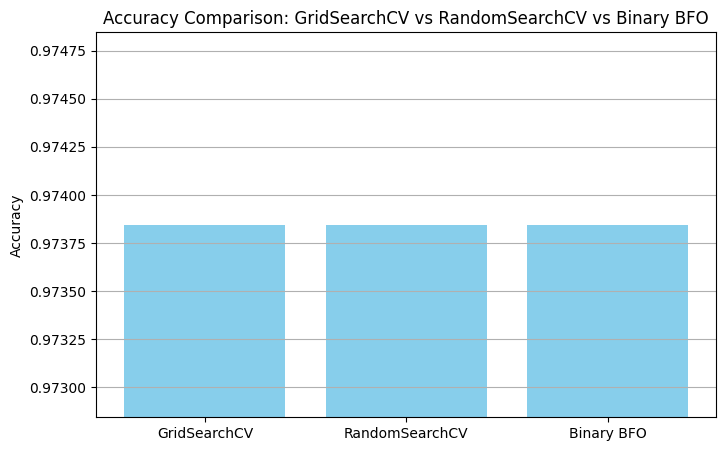

In [ ]:
print("=== Accuracy Comparison ===")
print(f"GridSearchCV Accuracy:     {svc_accuracy_bygridsearch:.4f} | Params: {svc_params_bygridsearch}")
print(f"RandomSearchCV Accuracy:   {svc_accuracy_byrandomsearch:.4f} | Params: {svc_params_byrandomsearch}")
print(f"Binary BFO Accuracy:       {fitness_history:.4f} | Params: {best_params }")


import matplotlib.pyplot as plt

results = {
    'GridSearchCV': svc_accuracy_bygridsearch,
    'RandomSearchCV': svc_accuracy_byrandomsearch,
    'Binary BFO': fitness_history
}

labels = list(results.keys())
accuracies = list(results.values())

plt.figure(figsize=(8, 5))
plt.bar(labels, accuracies, color='skyblue')
plt.ylabel('Accuracy')
plt.ylim(min(accuracies) - 0.001, max(accuracies) + 0.001)
plt.title('Accuracy Comparison: GridSearchCV vs RandomSearchCV vs Binary BFO')
plt.grid(axis='y')
plt.show()
